# Modeling Hodking-Huxely with latent neural ODEs  

In this example will show how to use the latentUDE framework to model a Hodking-Huxely neuron with dynamic synaptic inputs. 

In [1]:
using Pkg, Revise, Lux, Random, DifferentialEquations, SciMLSensitivity, ComponentArrays, Plots, MLUtils, OptimizationOptimisers, LinearAlgebra, Statistics, Printf
using IterTools: ncycle
using NeuroDynamics
using LuxCUDA
using BenchmarkTools

In [2]:
device = "cpu"
const dev = device == "gpu" ? gpu_device() : cpu_device()


(::LuxCPUDevice) (generic function with 5 methods)


## 1.Generating ground truth data 


### 1.1 Simulating Synaptic Inputs 

We will use the [Tsodyks-Markram model](https://www.pnas.org/doi/full/10.1073/pnas.94.2.719) to simulate the synaptic inputs to a neuron. We will generate multiple trajectories to later drive our Hodking-Huxley neuron model.

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


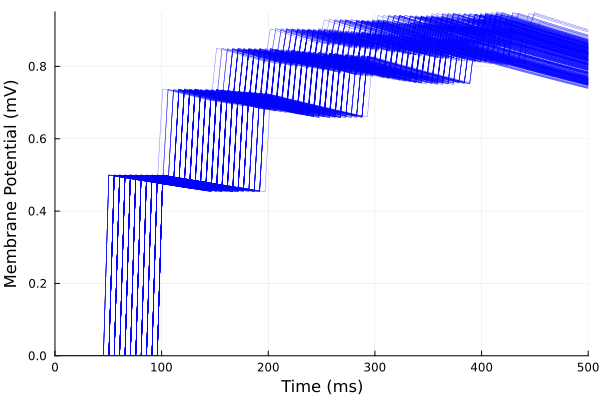

In [3]:
n_samples = 512
tspan = (0.0, 500.0)
ts = range(tspan[1], tspan[2], length=100)
ts = ts |> Array{Float32}
p =  [30, 1000, 50, 0.5, 0.005]
function TMS(x, p, t)
    v, R, gsyn = x
    tau, tau_u, tau_R, v0, gmax = p 
    dx₁ = -(v / tau_u)
    dx₂ = (1 - R) / tau_R
    dx₃ = -(gsyn / tau)
    return vcat(dx₁, dx₂, dx₃)
end

function epsp!(integrator)
    integrator.u[1] += integrator.p[4] * (1 - integrator.u[1])
    integrator.u[3] += integrator.p[5] * integrator.u[1] * integrator.u[2]
    integrator.u[2] -= integrator.u[1] * integrator.u[2]
end
prob = ODEProblem(TMS, [0.0, 1.0, 0.0], tspan, p)
function prob_func(prob, i, repeat)
    t_start = rand(50:100)
    t_int = rand(50:100)
    t_end = rand(400:450)
    epsp_ts = PresetTimeCallback(t_start:t_int:t_end, epsp!, save_positions=(false, false))
    remake(prob, callback=epsp_ts)
end

ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
U = solve(ensemble_prob, Tsit5(),  EnsembleThreads(); saveat=ts, trajectories=n_samples);
plot(U, vars=(1), alpha=0.5, color=:blue, lw=0.5, legend=false, xlabel="Time (ms)", ylabel="Membrane Potential (mV)")


### 1.2 Simulating a Hodgkin-Huxley Neuron 

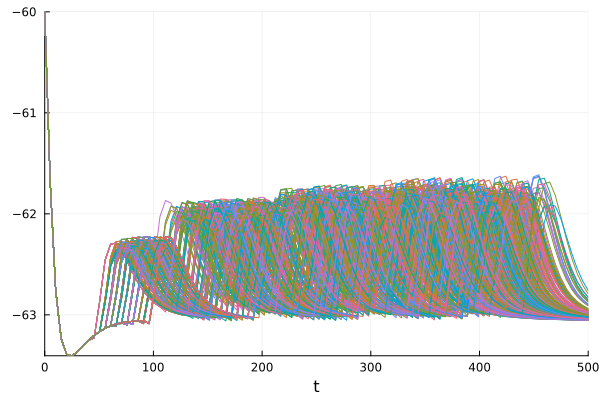

In [4]:
# Potassium ion-channel rate functions
alpha_n(v) = (0.02 * (v - 25.0)) / (1.0 - exp((-1.0 * (v - 25.0)) / 9.0))
beta_n(v) = (-0.002 * (v - 25.0)) / (1.0 - exp((v - 25.0) / 9.0))

# Sodium ion-channel rate functions
alpha_m(v) = (0.182 * (v + 35.0)) / (1.0 - exp((-1.0 * (v + 35.0)) / 9.0))
beta_m(v) = (-0.124 * (v + 35.0)) / (1.0 - exp((v + 35.0) / 9.0))

alpha_h(v) = 0.25 * exp((-1.0 * (v + 90.0)) / 12.0)
beta_h(v) = (0.25 * exp((v + 62.0) / 6.0)) / exp((v + 90.0) / 12.0)



function HH(x, p, t, u)
    gK, gNa, gL, EK, ENa, EL, C, ESyn, i = p
    v, n, m, h = x
    ISyn(t) = u[i](t)[end] * (ESyn - v)

    dx₁ = ((gK * (n^4.0) * (EK - v)) + (gNa * (m^3.0) * h * (ENa - v)) + (gL * (EL - v)) + ISyn(t)) / C
    dx₂ = (alpha_n(v) * (1.0 - n)) - (beta_n(v) * n)
    dx₃ = (alpha_m(v) * (1.0 - m)) - (beta_m(v) * m)
    dx₄ = (alpha_h(v) * (1.0 - h)) - (beta_h(v) * h)

    dx = vcat(dx₁, dx₂, dx₃, dx₄)
end

dxdt(x, p, t) = HH(x, p, t, U)

p = [35.0, 40.0, 0.3, -77.0, 55.0, -65.0, 1, 0, 1] 
# n, m & h steady-states
n_inf(v) = alpha_n(v) / (alpha_n(v) + beta_n(v))
m_inf(v) = alpha_m(v) / (alpha_m(v) + beta_m(v))
h_inf(v) = alpha_h(v) / (alpha_h(v) + beta_h(v))

v0 = -60
x0 = [v0, n_inf(v0), m_inf(v0), h_inf(v0)]
prob = ODEProblem(dxdt, x0, tspan, p)
prob_func(prob, i, repeat) = remake(prob, p=(p[1:end-1]..., i))
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
Y = solve(ensemble_prob, EnsembleThreads(); saveat=ts, trajectories=n_samples)
plot(Y, vars=1, label="v")


### 1.3 Creating a dataset and splitting it into train val test sets

In [5]:
Y_data = Array(Y) .|> Float32
U_data = Array(U) .|> Float32
input_dim = size(U_data)[1]
obs_dim = size(Y_data)[1]
(u_train, y_train), (u_val, y_val) = splitobs((U_data, Y_data); at=0.8, shuffle=true)
# Create dataloaders
train_loader = DataLoader((U_data, Y_data), batchsize=64, shuffle=false)
val_loader = DataLoader((U_data, Y_data), batchsize=64, shuffle=true);


## 2. Creating the model 

In [34]:
function create_model(n_states, ctrl_dim, obs_dim, context_dim, t_init, ts)
    rng = Random.MersenneTwister(1234)
    obs_encoder = Recurrent_Encoder(obs_dim, n_states, context_dim, 32, t_init)
    vector_field = Chain(Dense(n_states+ctrl_dim, 32, tanh), Dense(32, n_states, tanh))
    dynamics = ODE(vector_field, Euler(); saveat=ts, dt=ts[2]-ts[1])
    obs_decoder = Linear_Decoder(n_states, obs_dim, "None")   

    model = LatentUDE(obs_encoder=obs_encoder, dynamics=dynamics, obs_decoder=obs_decoder, device=dev)
    p, st = Lux.setup(rng, model)
    p = p |> ComponentArray{Float32} |> dev
    st = st |> dev
    return model, p, st
end

create_model (generic function with 1 method)

In [35]:
latent_dim = 4
context_dim = 0 # No need for context if we have ODE dynamics
t_init = 50
model, p, st = create_model(latent_dim, input_dim, obs_dim, context_dim, t_init, ts)
u, y = first(train_loader) .|> dev;


In [36]:
@btime model(y, u, ts, p, st)

  41.347 ms (272163 allocations: 79.55 MiB)


([0.8347313301385144 -2.910009085066255 … 183.34458549213406 185.2873904126376; -0.44741826108209104 0.7329153995049149 … -152.36591007756624 -153.95440835565813; 0.6972438092721787 1.5482618870949738 … 728.1659763157061 735.7175308576294; 0.31331258316468474 2.2880272069167287 … 633.3868677380298 639.9424631341159;;; -0.9037770216614177 -1.0625575044620046 … 186.02419671845897 187.966769578225; 0.7347024084994612 0.1453101345475748 … -154.0939207886884 -155.68235707592885; -0.3319487039481016 4.324731483288731 … 735.391368735407 742.9450461417462; -0.59490116053729 4.023688527746698 … 639.3761100197516 645.9340324010567;;; -1.3381988347844977 -2.2445480152372017 … 184.17141067834314 186.11025560495136; -0.0388910201563237 -0.835421317702457 … -153.33550541197053 -154.9198629695809; 0.07621838518233792 5.413606060669045 … 733.0686477913575 740.6190948533648; 0.25329385114160824 6.324392973140335 … 637.8164122542414 644.3706774234882;;; … ;;; -2.8150107221161815 -3.312130226077919 … 184

## 3. Train the model via variational inference

In [40]:
function train(model, p, st, train_loader, val_loader, epochs, print_every)
    
    epoch = 0
    L = frange_cycle_linear(epochs+1, 0.0f0, 1.0f0, 1, 0.5)
    losses = []
    best_model_params = nothing
    best_metric = Inf
    stime = time()

    function loss(p, u, y, ts=ts)
        u, y = u |> dev, y |> dev
        ŷ, û, x̂₀, _ = model(y, u, ts, p, st)
        batch_size = size(y)[end]
        recon_loss = mse(ŷ, y)/batch_size + 10*mse(ŷ[:,1,:], y[:,1,:])/batch_size
        kl_loss = kl_normal(x̂₀[1], x̂₀[2])/batch_size
        l =  0.5*recon_loss + L[epoch+1]*kl_loss
        return l, recon_loss, kl_loss
    end


    callback = function(opt_state, l, recon_loss, kl_loss)
        θ = opt_state.u
        push!(losses, l)
        if length(losses) % length(train_loader) == 0
            epoch += 1
        end

        if length(losses) % (length(train_loader)*print_every) == 0
            t_epoch = time() - stime
            @printf("Time/epoch %.2fs \t Current epoch: %d \t Loss: %.2f, Reconstruction: %d, KL: %.2f\n", t_epoch/print_every, epoch, losses[end], recon_loss, kl_loss)
            u, y = first(train_loader) .|> dev
            batch_size = size(y)[end]
            ŷ, _, x = predict(model, y, u, ts, θ, st, 20)
            y, ŷ, x = y |> cpu, ŷ |> cpu, x |> cpu
            ŷ_mean = dropdims(mean(ŷ, dims=4), dims=4)
            val_mse = mse(ŷ_mean, y)/batch_size
            @printf("Validation MSE: %.2f\n", val_mse)
            if val_mse < best_metric
                best_metric = val_mse
                @printf("Saving best model \n")
                best_model_params = copy(θ)
            end

            pl = plot(transpose(y[1:1, :, 1]), label="True", lw=2.0)
            plot!(pl, transpose(ŷ_mean[1:1, :, 1]), label="Predicted", lw=2.0, xlabel="Time (ms)", ylabel="Membrane Potential (mV)")
            display(pl)
            stime = time()
        
        end
        return false
    end

    adtype = Optimization.AutoZygote()
    optf = OptimizationFunction((p, _ , u, y) -> loss(p, u, y), adtype)
    optproblem = OptimizationProblem(optf, p)
    result = Optimization.solve(optproblem, ADAMW(5e-4), ncycle(train_loader, epochs); callback)
    return result, losses, model, best_model_params
    
end


train (generic function with 1 method)

Time/epoch 1.78s 	 Current epoch: 100 	 Loss: 85.21, Reconstruction: 44, KL: 320.07
Validation MSE: 42.91
Saving best model 
Time/epoch 1.77s 	 Current epoch: 200 	 Loss: 130.77, Reconstruction: 31, KL: 290.30
Validation MSE: 27.13
Saving best model 
Time/epoch 1.77s 	 Current epoch: 300 	 Loss: 169.98, Reconstruction: 39, KL: 251.67
Validation MSE: 29.36
Time/epoch 1.76s 	 Current epoch: 400 	 Loss: 537.94, Reconstruction: 737, KL: 212.49
Validation MSE: 683.02
Time/epoch 1.77s 	 Current epoch: 500 	 Loss: 598.80, Reconstruction: 925, KL: 136.82
Validation MSE: 793.21
Time/epoch 1.83s 	 Current epoch: 600 	 Loss: 614.08, Reconstruction: 954, KL: 137.01
Validation MSE: 768.33
Time/epoch 1.76s 	 Current epoch: 700 	 Loss: 606.21, Reconstruction: 965, KL: 123.49
Validation MSE: 689.89
Time/epoch 1.75s 	 Current epoch: 800 	 Loss: 607.36, Reconstruction: 966, KL: 124.13
Validation MSE: 716.89
Time/epoch 1.77s 	 Current epoch: 900 	 Loss: 508.38, Reconstruction: 840, KL: 88.35
Validation M

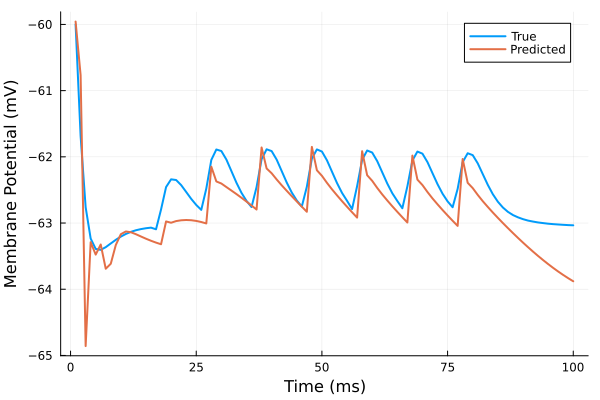

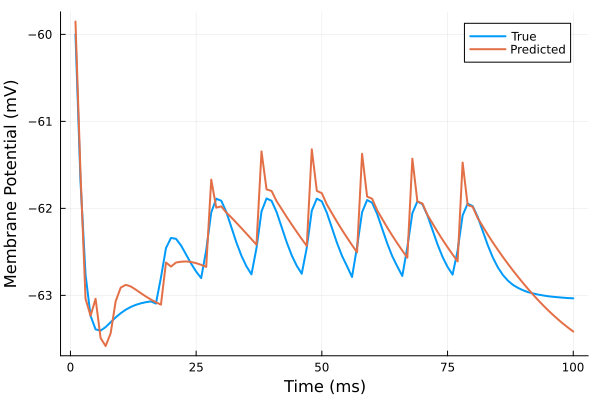

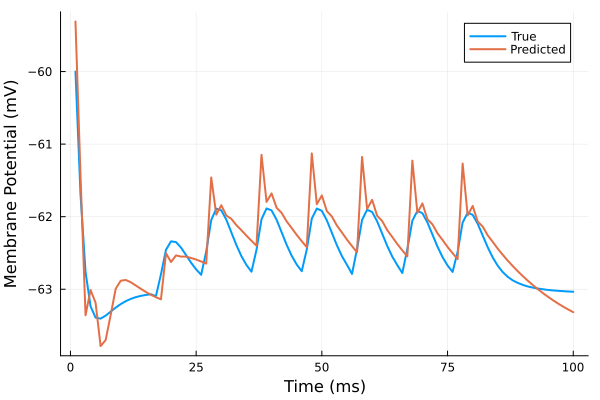

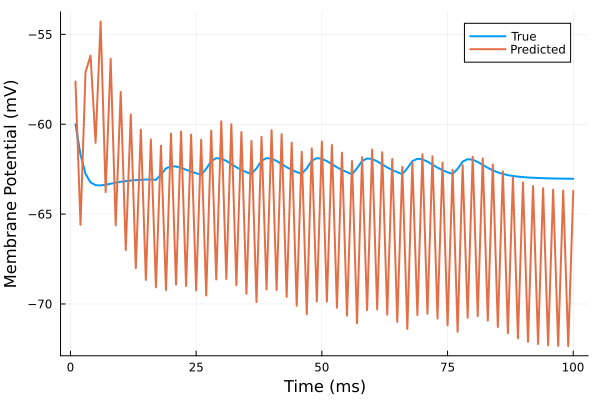

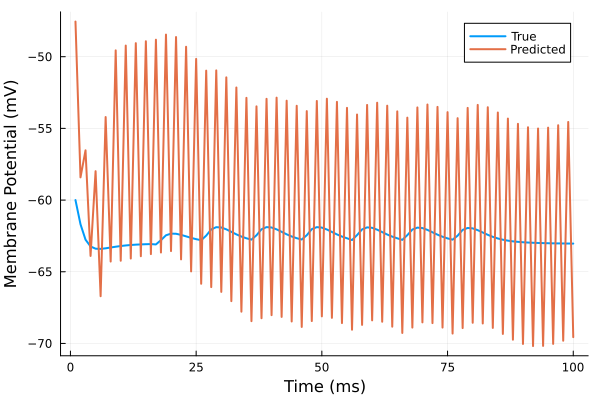

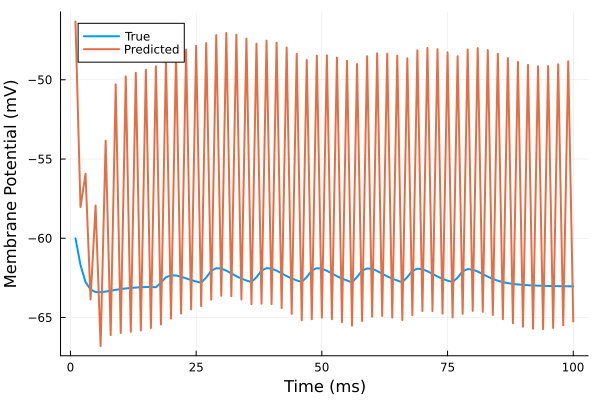

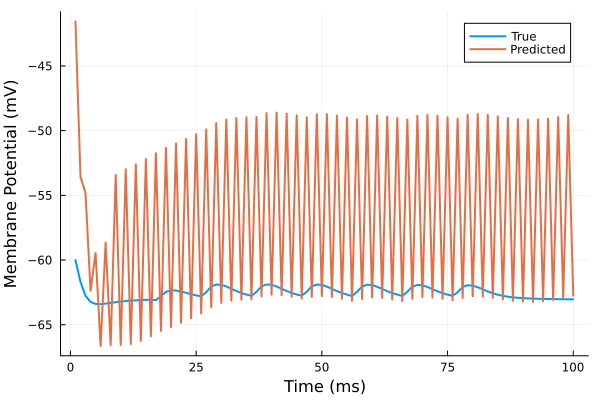

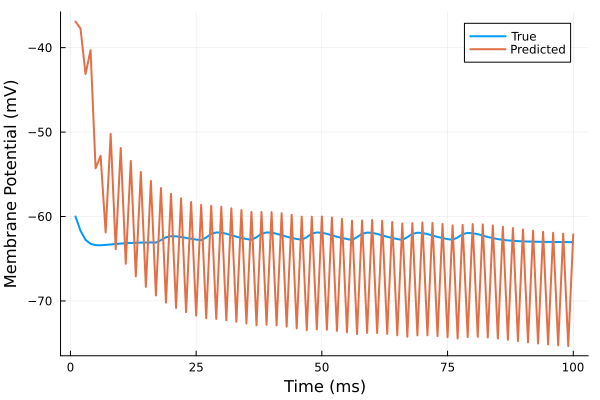

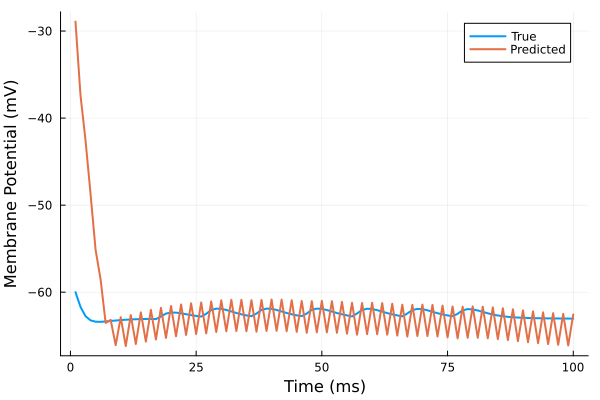

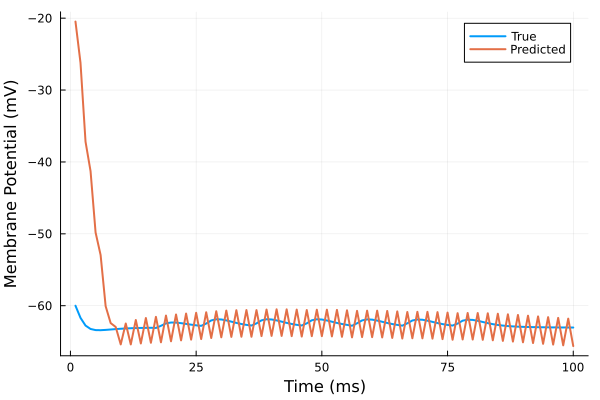

(retcode: Default
u: (obs_encoder = (linear_net = (weight = Float32[-0.39945439 0.012915343 -0.3828165 -0.3118724; 0.31539577 -0.080469795 -0.038352314 -0.023752606; … ; 0.20265412 0.07490755 -0.3665481 -0.0033423516; -0.39997452 -0.24347025 0.07290354 0.1453355], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), init_net = (layer_1 = Float32[], layer_2 = (weight_i = Float32[0.052744653 0.15303005 … 0.28184482 0.20090011; 0.30710965 0.0088823605 … 0.24690254 0.08653628; … ; -0.037796874 -0.033324663 … 0.087169 0.35084423; 0.28784263 0.0495533 … -0.10687802 -0.15192205], weight_h = Float32[-0.18259352 0.24891403 … -0.20829812 -0.025192495; -0.12852044 0.25444573 … 0.15572828 -0.056366026; … ; 0.4332858 0.03403572 … 0.5638663 0.4214287; 0.18419887 0.17320134 … 0.30384067 -0.028723188], bias = Float32[0.008430263; 0.021728922; … ; 0.103025265; 0.11185151;;]), layer_3 = (layer_1 = (weight = Float32[0.15152633 -0.63796455 … -0.44817185 0.052571107; 0.24859987 0.51219684 … 0.47349575 0.32014772; 0.

In [42]:
result, losses, model, best_p = train(model, best_p, st, train_loader, val_loader, 1000, 100)


In [59]:
u, y = first(train_loader) .|> dev
batch_size = size(y)[end]
ŷ, _, x = predict(model, y, u, ts, best_p, st, 50)
y, ŷ, x = y |> cpu, ŷ |> cpu, x |> cpu
ŷ_mean = dropdims(mean(ŷ, dims=4), dims=4);


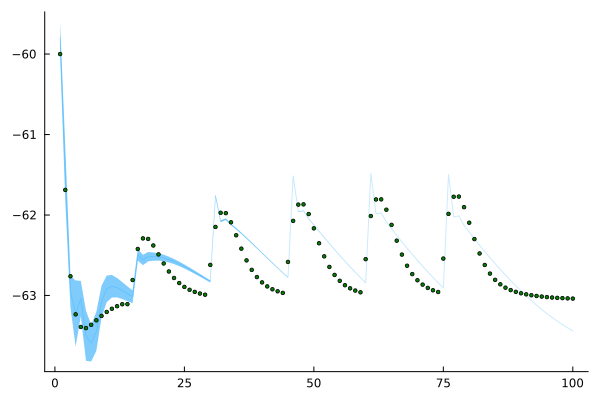

In [67]:
plot_preds(y[1:1,:,:], ŷ[1:1,:,:,:],5)

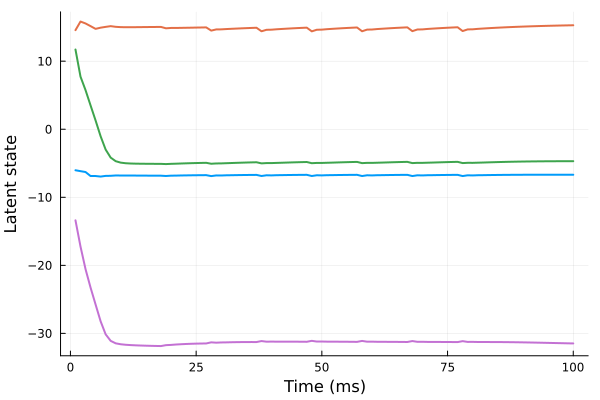

In [44]:
x_mean = dropmean(x, dims=4)
plot(transpose(x_mean[:,:,1]), label=nothing, lw=2.0, xlabel="Time (ms)", ylabel="Latent state")

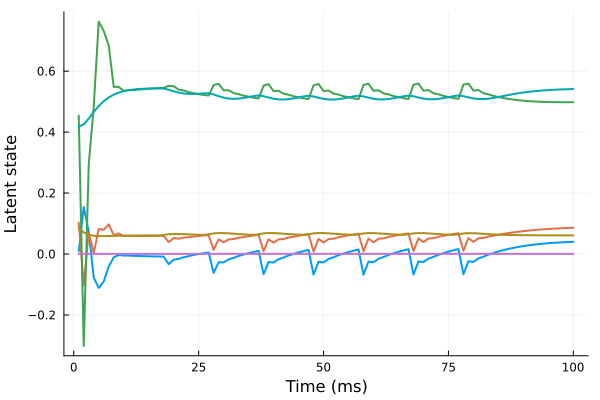

In [57]:
plot(transpose(ŷ_mean[2:end,:,1]), label=nothing, lw=2.0, xlabel="Time (ms)", ylabel="Latent state")
plot!(transpose(y[2:end,:,1]), label=nothing, lw=2.0, xlabel="Time (ms)", ylabel="Latent state")